In [1]:
!pip uninstall -y fastai && pip install -q fastai==1.0.61
!sed -i 's/from collections import abc,  Counter, defaultdict, Iterable, namedtuple, OrderedDict/from collections import abc, Counter, defaultdict, namedtuple, OrderedDict\nfrom collections.abc import Iterable/' /opt/conda/lib/python3.11/site-packages/fastai/imports/core.py

In [2]:
!pip install -q loguru accelerate

In [27]:
# The dataloader expects all images to be in the same folder, regardless of the split, however the dataset doesnt come in that form
!mkdir -p ./Dataset_estetica/Regressao/all
!cp -r ./Dataset_estetica/Regressao/train/* ./Dataset_estetica/Regressao/all/ 
!cp -r ./Dataset_estetica/Regressao/valid/* ./Dataset_estetica/Regressao/all/

In [28]:
!du -sh ./Dataset_estetica/Regressao

229M	./Dataset_estetica/Regressao


In [3]:
from pathlib import Path
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from datetime import datetime
from loguru import logger
from accelerate import Accelerator

In [29]:
accelerator = Accelerator()

In [4]:
from fastai.vision import *
from fastai.callbacks import SaveModelCallback
from fastai.metrics import error_rate

# Import for various utilities
from shutil import copyfile
import matplotlib.pyplot as plt
import operator
from PIL import Image
from sys import intern   # For the symbol definitions

In [5]:
path = Path(os.path.expanduser("./Dataset_estetica/Regressao"))

In [6]:
df = pd.read_csv(path / 'labels.csv')

In [138]:
# Making our 'default' transformation
tfms = get_transforms(do_flip=False, flip_vert=False, max_rotate=None, 
                      max_warp=None, max_lighting=None, max_zoom=1.0)
# Show how many transformations were created
print('Transforms = ', len(tfms))

# Create the databunch with transformations (tfms) and size (size)
data = (ImageList.from_csv(path, 'labels.csv', folder='all', suffix='.jpg')
        .split_from_df(col='valid')
        .label_from_df(1,label_cls=FloatList)
        .transform(tfms, size=448)
        .databunch()
       )

# Considering GPU memory capacity, we adjust batch_size as needed...
# If using ResNet34 or lower:
# data.batch_size = 64

# If using ResNet50:
# data.batch_size = 32

# If using ResNet101:
data.batch_size = 16

# Show what was created...
data

Transforms =  2


ImageDataBunch;

Train: LabelList (2509 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: FloatList
0.17,0.0,0.0,0.0,0.0
Path: Dataset_estetica/Regressao;

Valid: LabelList (630 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: FloatList
0.5,0.0,0.33,0.67,0.67
Path: Dataset_estetica/Regressao;

Test: None

In [139]:
def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

torch.Size([16, 3, 448, 448])


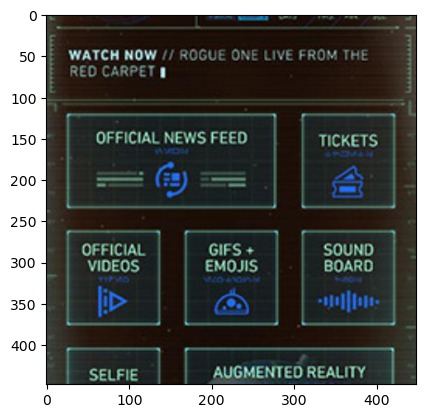

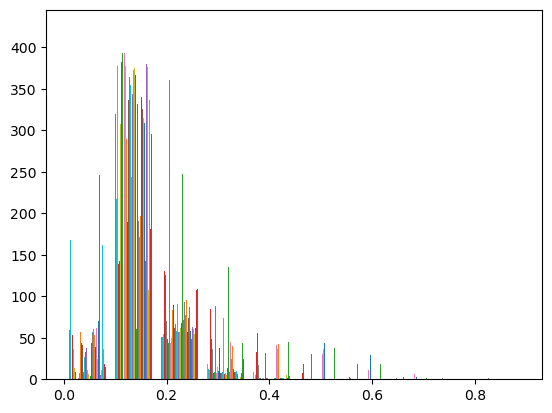

In [146]:
for i in data.dl():
    print(i[0].shape)
    plt.imshow(i[0][0].cpu().permute(1, 2, 0))
    plt.show()
    plt.hist(i[0].cpu()[0][0])
    plt.show()
    break

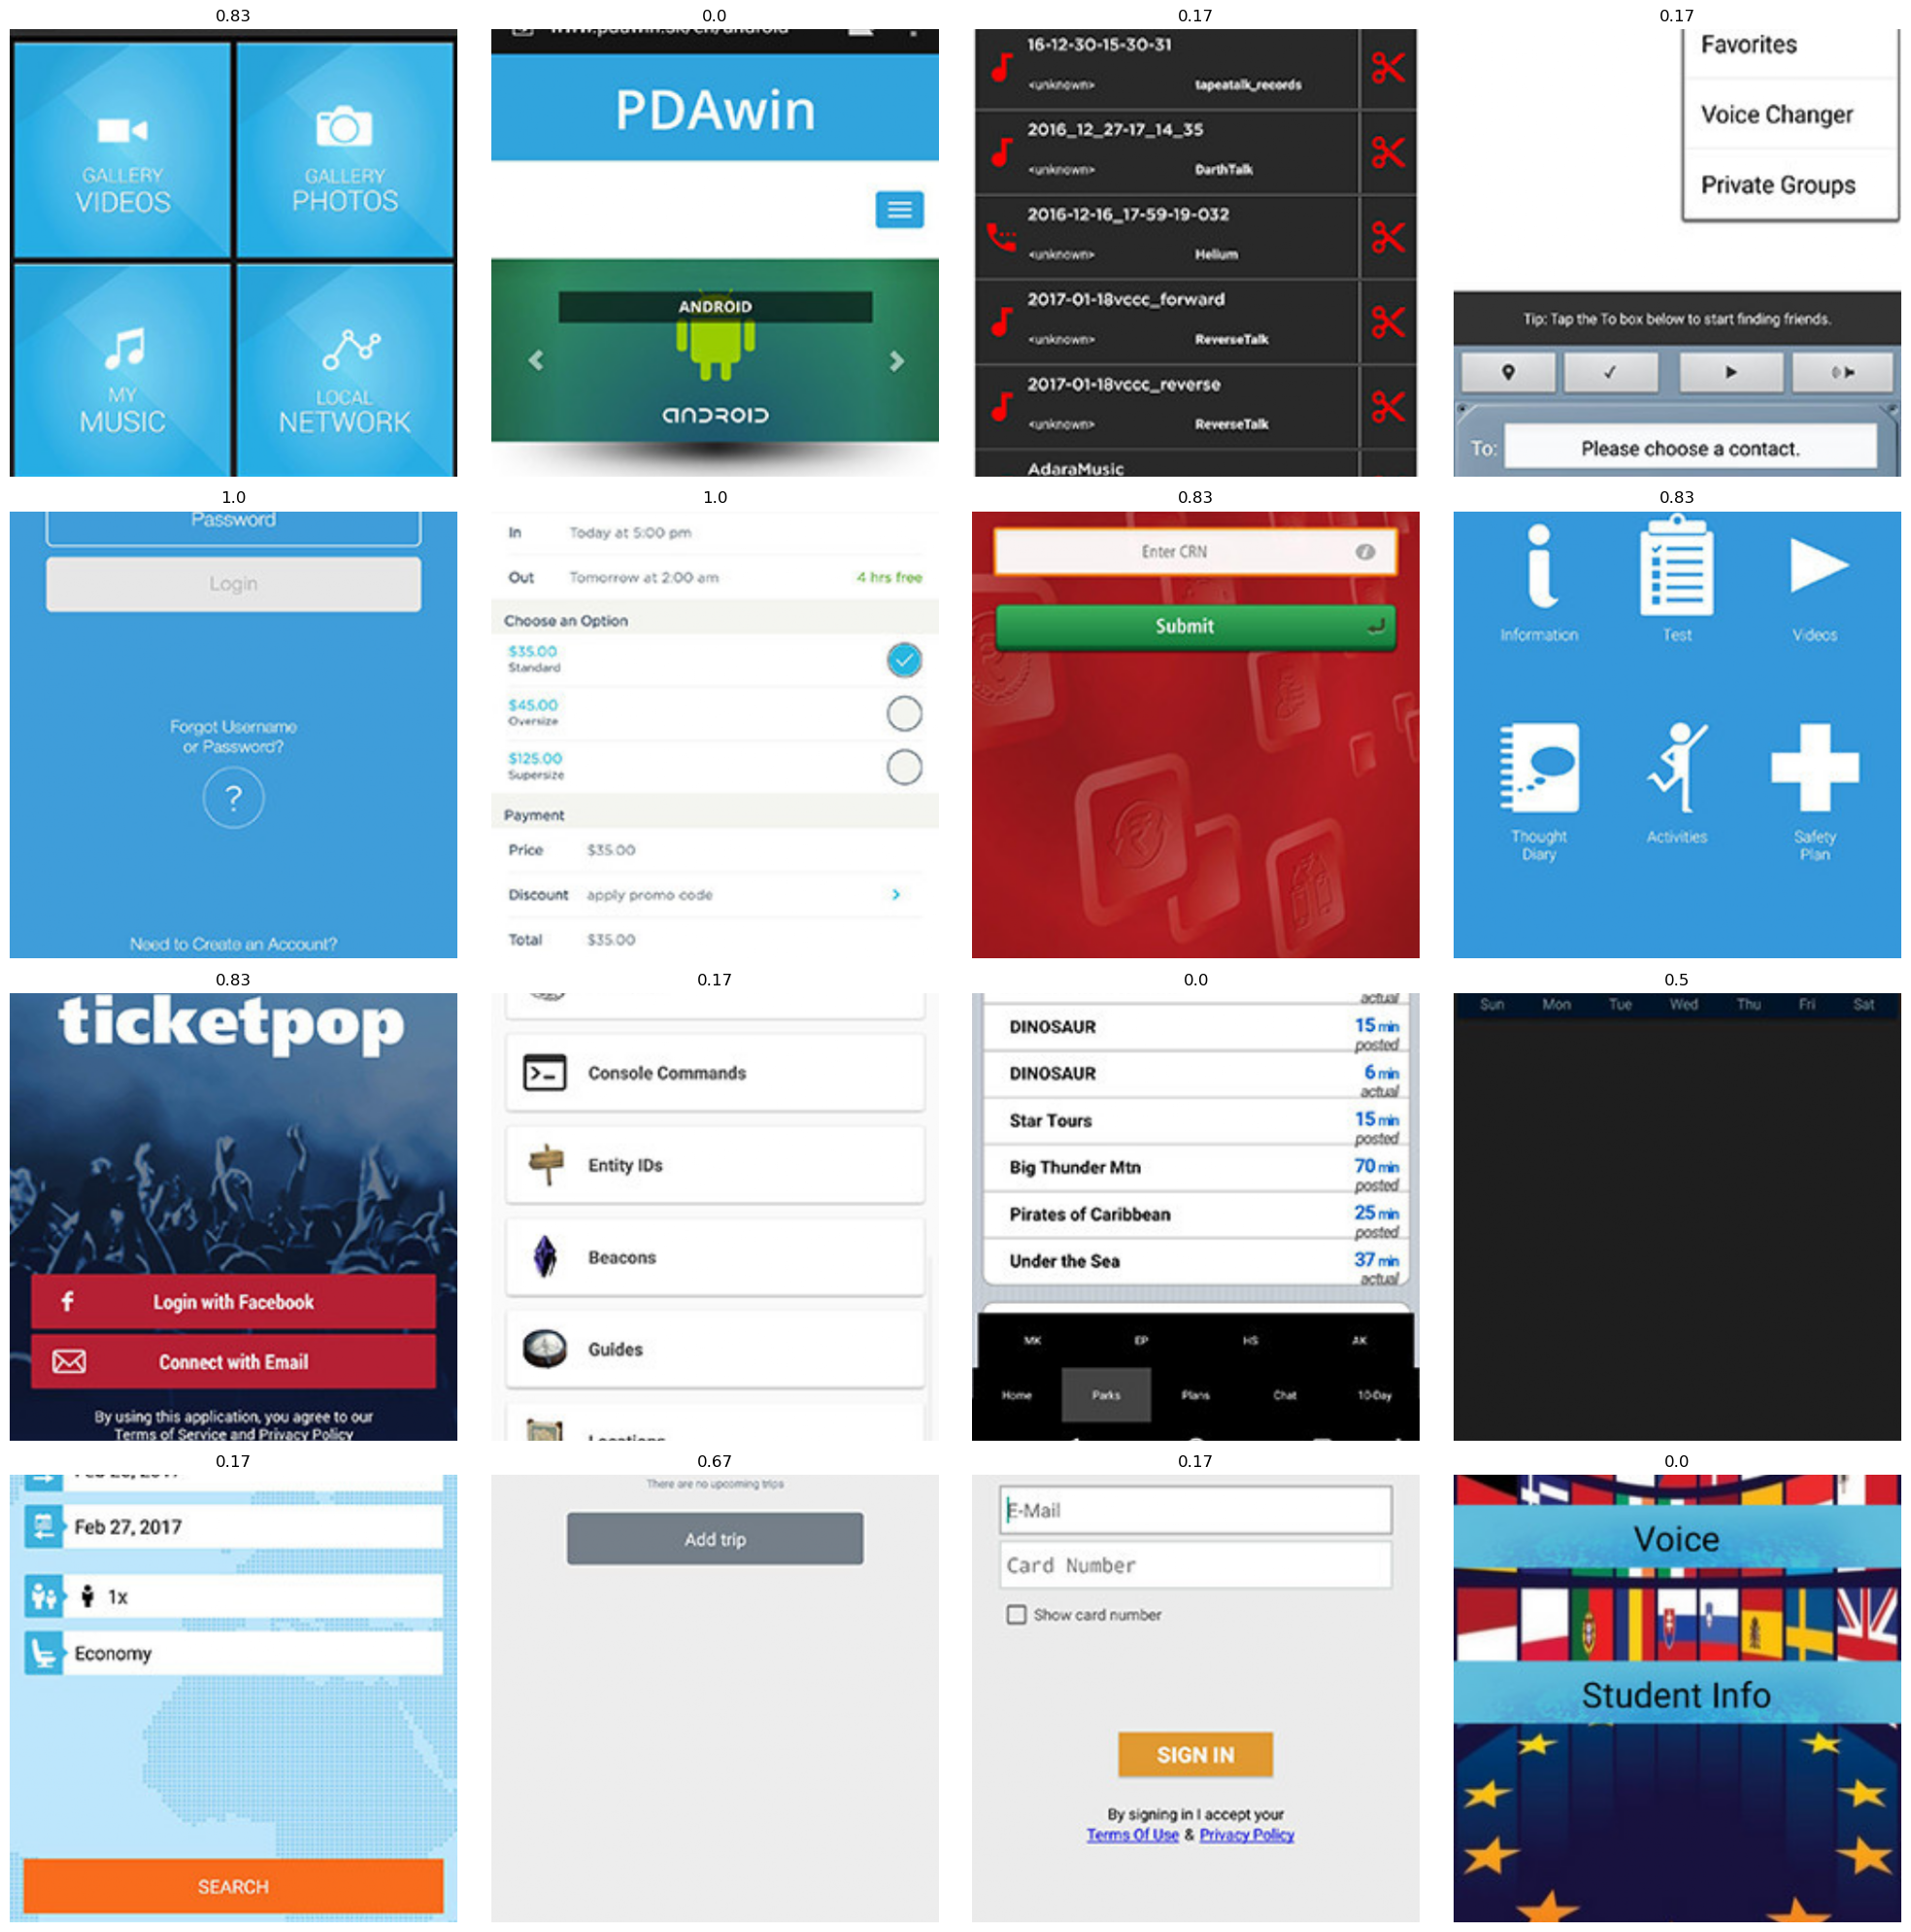

In [9]:
data.show_batch(rows=4, figsize=(20,20))

In [10]:
learn = cnn_learner(data, models.resnet101, metrics=[mean_squared_error])
learn.loss = MSELossFlat

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 188MB/s]  


In [11]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [12]:
learn.fit(15, callbacks=[SaveModelCallback(learn, every='epoch', monitor='mean_squared_error', name='model101-fit-best')]) 

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,


In [13]:
learn.fit_one_cycle(10, callbacks=[SaveModelCallback(learn, every='epoch', monitor='mean_squared_error', name='model101-1cycle-best')]) 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.58E-07


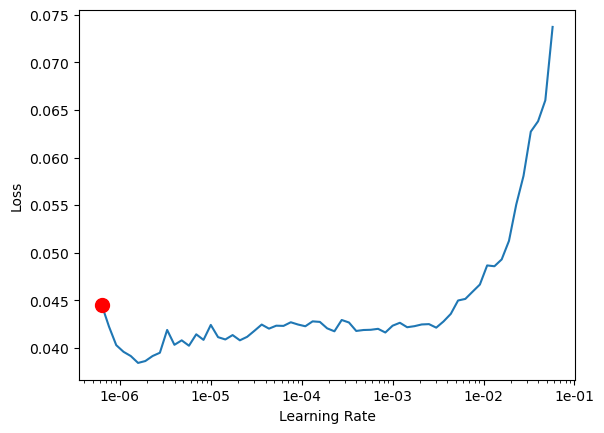

In [17]:
learn = cnn_learner(data, models.resnet101, metrics=[mean_squared_error])
learn.load('model101-1cycle-best_7')
learn.lr_find()
learn.recorder.plot(suggestion=True)

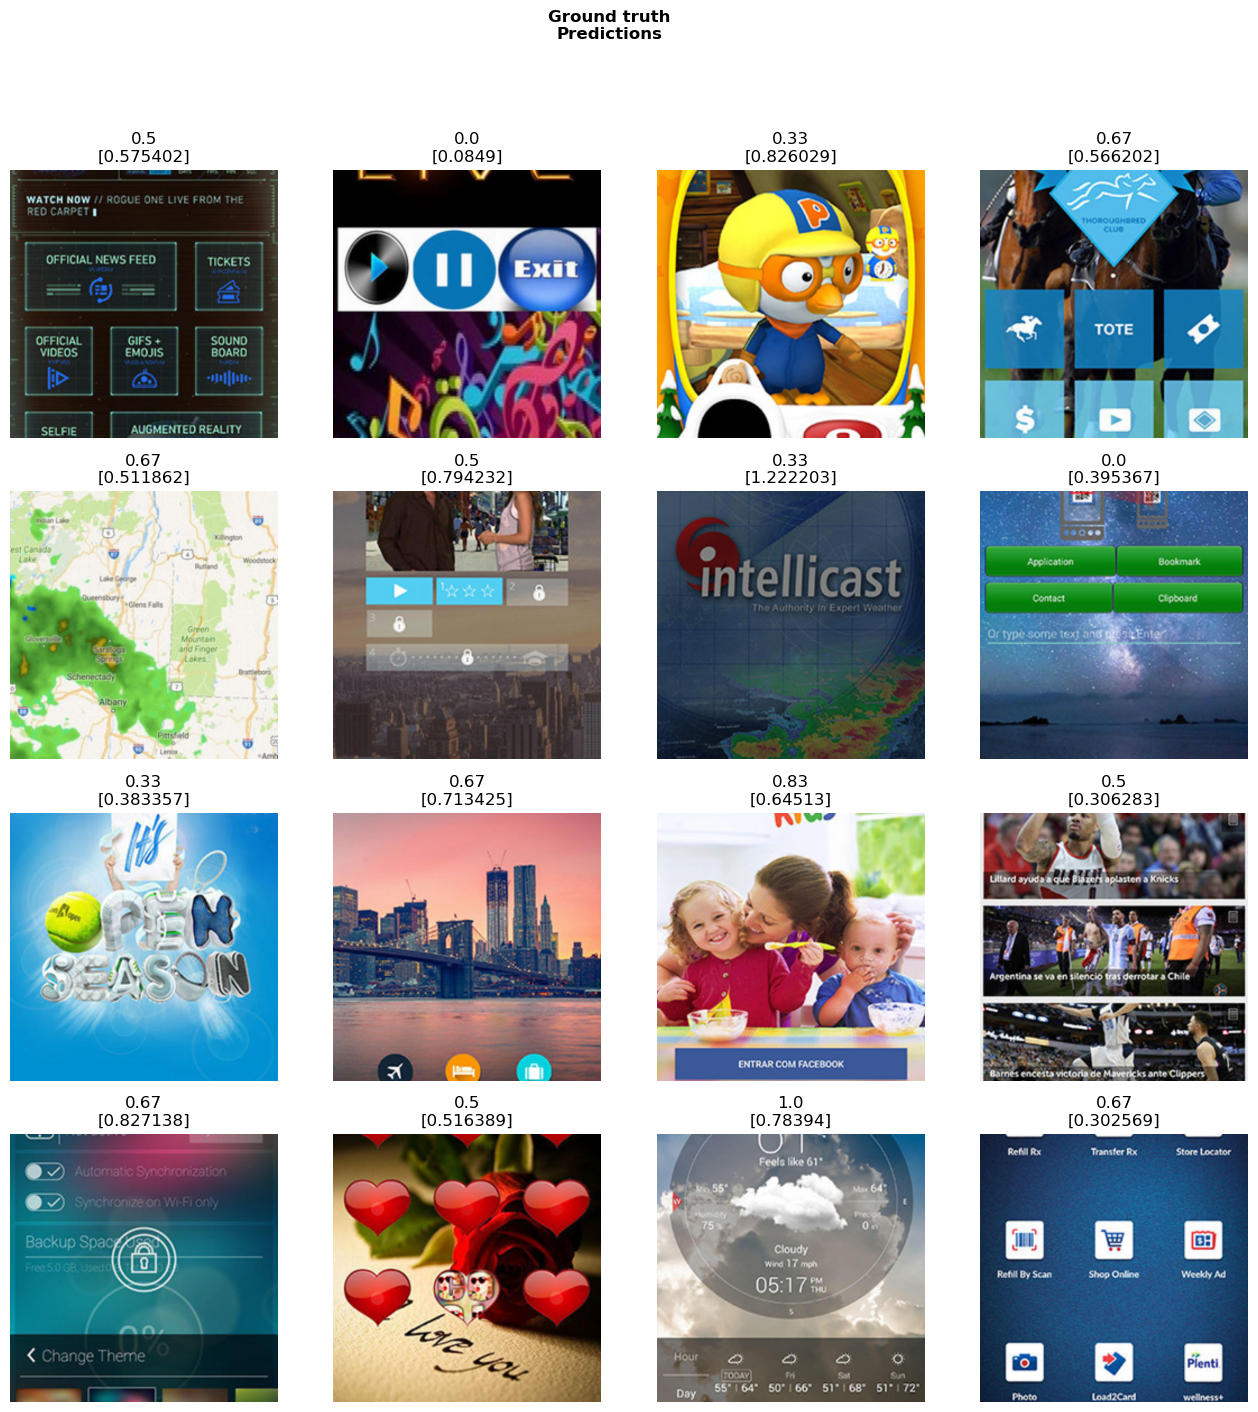

In [18]:
learn.show_results() 

In [54]:
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={'row_pct': 0.44709739882498234, 'col_pct': 0.7381632131117334, 'padding_mode': 'reflection'}, do_run=True, is_random=True, use_on_y=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={'padding_mode': 'reflection', 'row_pct': 0.5, 'col_pct': 0.5}, do_run=True, is_random=True, use_on_y=True)])

In [40]:
type(learn)

fastai.basic_train.Learner

In [42]:
learn.export("./model123")

In [44]:
model = torch.load(path/"model123")

In [45]:
type(model)

dict

In [46]:
type(model["model"])

torch.nn.modules.container.Sequential

In [47]:
model.keys()

dict_keys(['opt_func', 'loss_func', 'metrics', 'true_wd', 'bn_wd', 'wd', 'train_bn', 'model_dir', 'callback_fns', 'cb_state', 'model', 'data', 'cls'])

In [24]:
class AppstheticsDataset(Dataset):
    def __init__(self, root, split, transform=None):
        self.root_path = Path(root)
        self.dataset = pd.read_csv(path / 'labels.csv')
        if split=="valid":
            self.dataset = self.dataset[self.dataset["valid"] == True]
        else:
            self.dataset = self.dataset[self.dataset["valid"] == False]
        self.split = split
        self.transform = transform
        
    
    def __len__(self):
        return len(self.dataset.values)
        
    def __getitem__(self, idx):
        row = self.dataset.iloc[idx]
        image_path = row["image"]
        score = row["score"]
        image = Image.open(self.root_path / f"{self.split}/{image_path}.jpg").convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(score).float()

In [101]:
resnet_transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [158]:
test_dataset = AppstheticsDataset(os.path.expanduser("./Dataset_estetica/Regressao"), split="train", transform=resnet_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

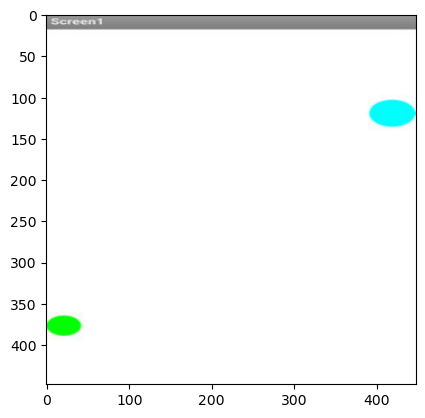

In [159]:
plt.imshow(test_dataset[0][0].permute(1,2,0))
plt.show()

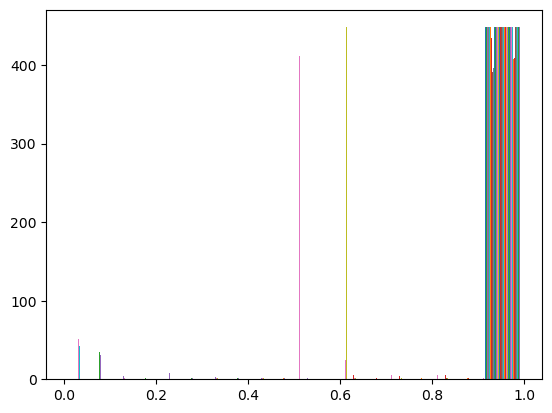

In [160]:
plt.hist(test_dataset[0][0][0])
plt.show()

In [161]:
model = accelerator.prepare(model)

  0%|          | 0/78 [00:00<?, ?it/s]

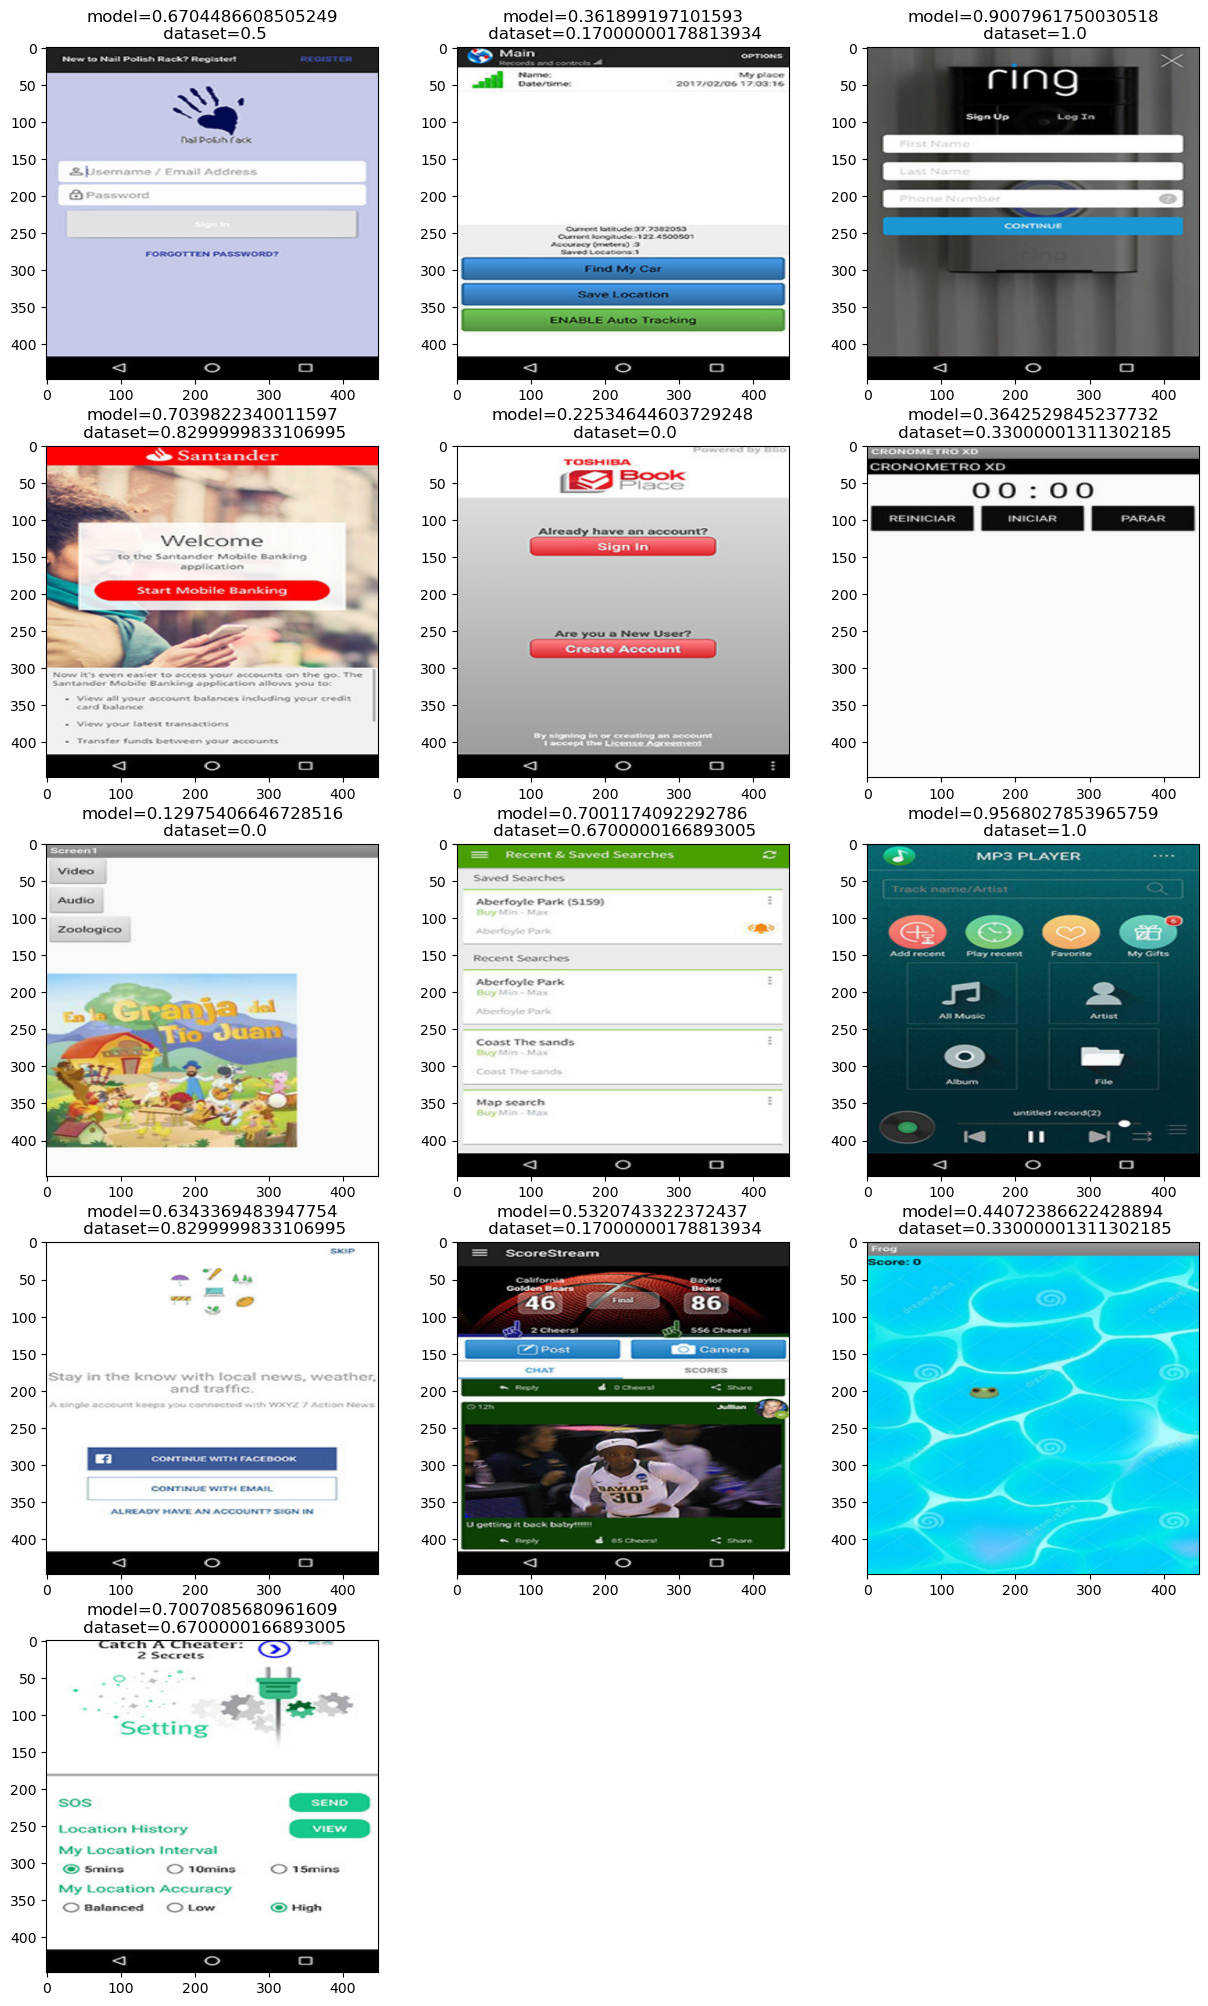

In [163]:
fig = plt.figure(figsize=(15, 25)) 

predicted_scores = []
targets = []

#for x in range(8):
for i, data in tqdm(enumerate(test_loader, 0),total=int(len(test_dataset)/32)):
    inputs, labels = data[0], data[1]
    outputs = model["model"](inputs)
    
    # outputs = learn.predict(inputs)

    if not i > 12:
        fig.add_subplot(5, 3, i+1)
        plt.imshow(inputs[0].permute(1, 2, 0).cpu())
        #print(inputs[0].permute(1, 2, 0))
        #break
        plt.title(f"model={outputs[0].item()}\n dataset={labels[0].item()}")
    predicted_scores.append(outputs[0].item())
    targets.append(labels[0].item())
        
plt.show()

In [ ]:
plt.hist(targets,range=[0,1])
plt.show()

In [ ]:
plt.hist(predicted_scores)
plt.show()

In [ ]:
max(predicted_scores)

In [ ]:
criterion = nn.MSELoss()

In [ ]:
criterion(torch.tensor(predicted_scores), torch.tensor(targets))